# 20. Segmentation map으로 도로 이미지 만들기

<br><br><br>

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers

# 1. 데이터 전처리

number of train examples : 1000


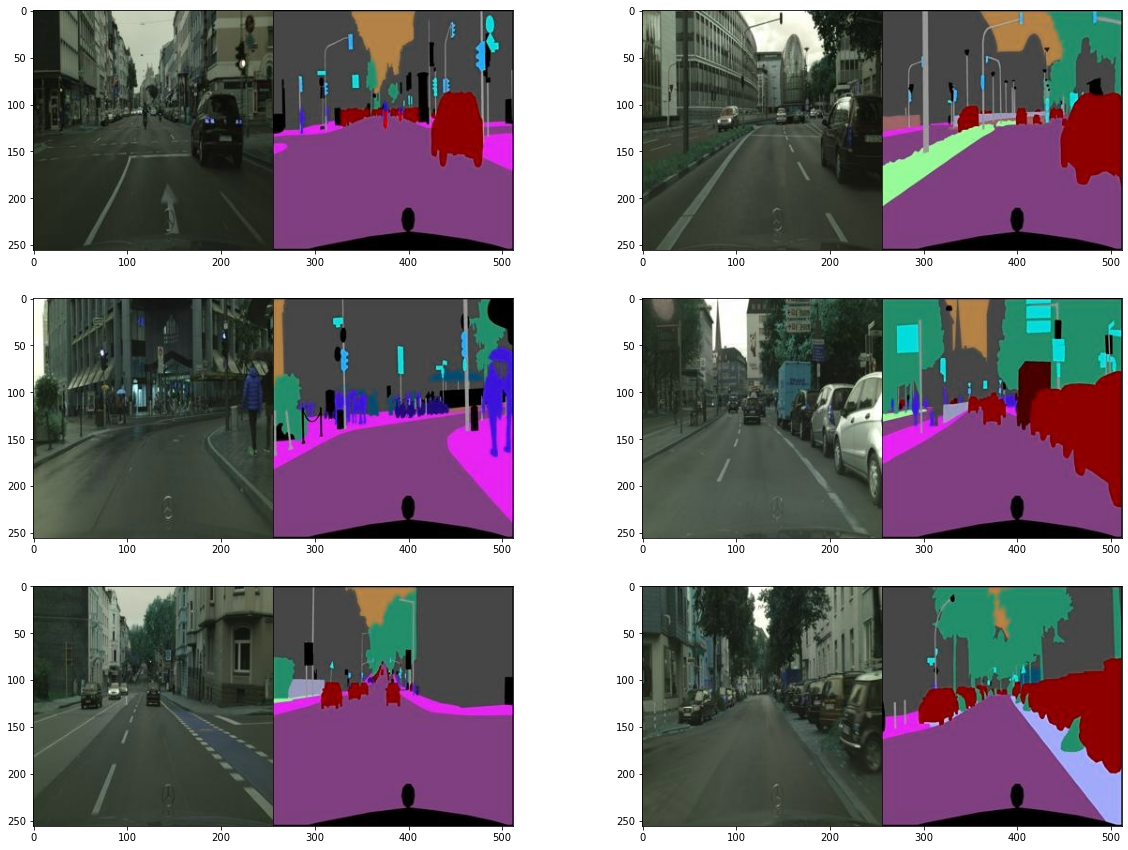

In [8]:
data_path = os.getenv('HOME') + '/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [9]:
# 이미지 shape 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


## 2-1. 이미지 분할

In [10]:
# 2개의 이미지로 분할하여 사용
# 정규화
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

  # 비정규화
def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

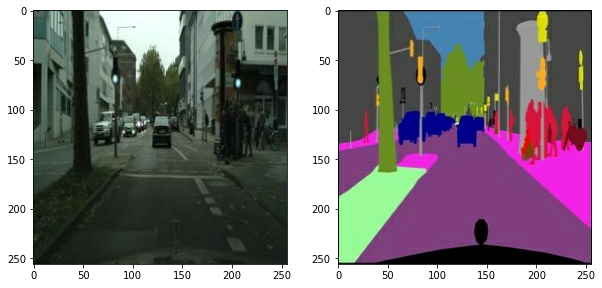

In [11]:
f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## 2-2. augmentation

In [13]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:  # tf.random.uniform(()) : 0과 1사이의 랜덤값을 만듬, shape=()
        padded = tf.pad(stacked, _pad, "REFLECT")  # 이미지에 제로패딩 적용
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]

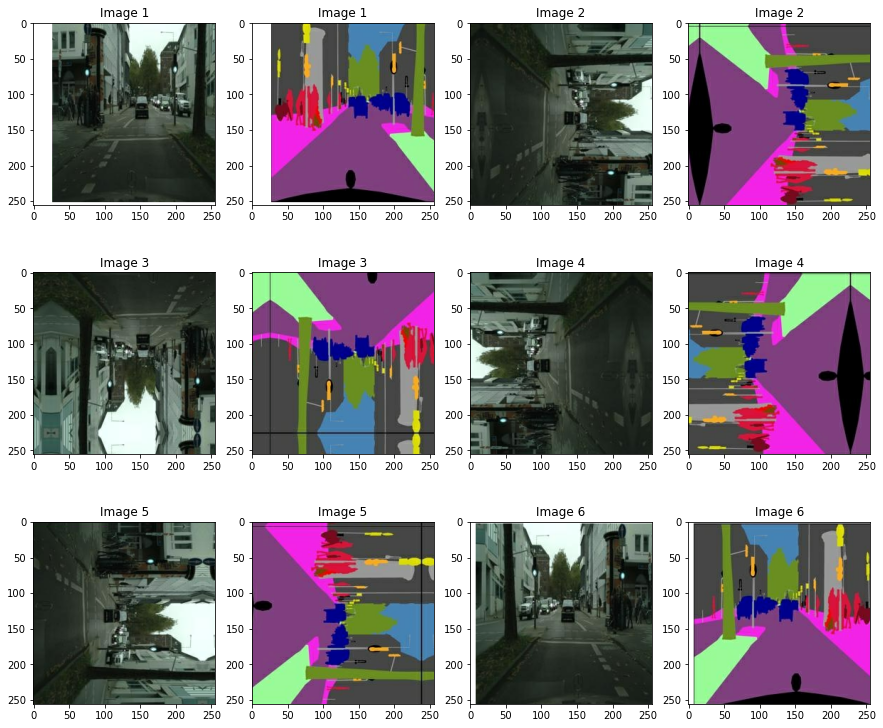

In [14]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

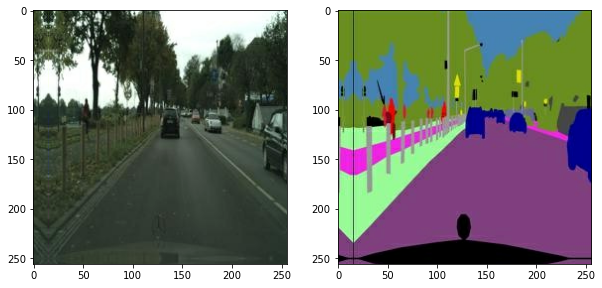

In [15]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

<br><br><br><br>

# 2. 모델 구성
- U-Net Generator

## 2-1. Generator

In [16]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [17]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [18]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]  # Encoder의 마지막 출력은 Decoder로 직접 입력되므로 skip connection의 대상이 아니므로 [:-1]을 해준다.
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [19]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## 2-2. Discriminator 구성¶

In [20]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [21]:
# 출력 크기 확인
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [22]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [23]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

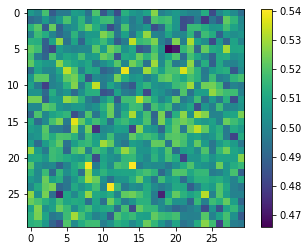

In [24]:
# test visualization
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

<br><br><br><br>

# 3. 모델 학습

In [25]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [26]:
# optimizer 설정
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [27]:
# 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [28]:
EPOCHS = 20

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8090                     
L1_loss:0.3280                     
Discriminator_loss:1.2240

EPOCH[1] - STEP[20]                     
Generator_loss:1.0676                     
L1_loss:0.3112                     
Discriminator_loss:1.1238

EPOCH[1] - STEP[30]                     
Generator_loss:1.2577                     
L1_loss:0.2294                     
Discriminator_loss:1.0949

EPOCH[1] - STEP[40]                     
Generator_loss:1.3600                     
L1_loss:0.2391                     
Discriminator_loss:0.7027

EPOCH[1] - STEP[50]                     
Generator_loss:1.5261                     
L1_loss:0.2254                     
Discriminator_loss:0.6894

EPOCH[1] - STEP[60]                     
Generator_loss:2.0643                     
L1_loss:0.2185                     
Discriminator_loss:1.3487

EPOCH[1] - STEP[70]                     
Generator_loss:2.2592                     
L1_loss:0.2161                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.9791                     
L1_loss:0.1835                     
Discriminator_loss:0.3577

EPOCH[3] - STEP[80]                     
Generator_loss:1.4759                     
L1_loss:0.1826                     
Discriminator_loss:1.0134

EPOCH[3] - STEP[90]                     
Generator_loss:2.0149                     
L1_loss:0.2209                     
Discriminator_loss:0.5300

EPOCH[3] - STEP[100]                     
Generator_loss:2.5188                     
L1_loss:0.2086                     
Discriminator_loss:0.6849

EPOCH[3] - STEP[110]                     
Generator_loss:1.7443                     
L1_loss:0.2176                     
Discriminator_loss:0.4978

EPOCH[3] - STEP[120]                     
Generator_loss:1.4971                     
L1_loss:0.2030                     
Discriminator_loss:0.5084

EPOCH[3] - STEP[130]                     
Generator_loss:2.5877                     
L1_loss:0.1976                

EPOCH[5] - STEP[130]                     
Generator_loss:2.0296                     
L1_loss:0.1984                     
Discriminator_loss:0.5767

EPOCH[5] - STEP[140]                     
Generator_loss:2.9797                     
L1_loss:0.2169                     
Discriminator_loss:0.3080

EPOCH[5] - STEP[150]                     
Generator_loss:1.3984                     
L1_loss:0.1731                     
Discriminator_loss:0.6397

EPOCH[5] - STEP[160]                     
Generator_loss:0.4342                     
L1_loss:0.1937                     
Discriminator_loss:1.2890

EPOCH[5] - STEP[170]                     
Generator_loss:1.6692                     
L1_loss:0.1690                     
Discriminator_loss:1.0936

EPOCH[5] - STEP[180]                     
Generator_loss:1.9450                     
L1_loss:0.1854                     
Discriminator_loss:0.4868

EPOCH[5] - STEP[190]                     
Generator_loss:1.9993                     
L1_loss:0.1836             

EPOCH[7] - STEP[190]                     
Generator_loss:1.9702                     
L1_loss:0.2350                     
Discriminator_loss:0.4003

EPOCH[7] - STEP[200]                     
Generator_loss:0.6872                     
L1_loss:0.2233                     
Discriminator_loss:0.8665

EPOCH[7] - STEP[210]                     
Generator_loss:3.0049                     
L1_loss:0.1870                     
Discriminator_loss:0.5831

EPOCH[7] - STEP[220]                     
Generator_loss:0.2610                     
L1_loss:0.2078                     
Discriminator_loss:1.7550

EPOCH[7] - STEP[230]                     
Generator_loss:2.4827                     
L1_loss:0.2314                     
Discriminator_loss:0.6260

EPOCH[7] - STEP[240]                     
Generator_loss:3.0499                     
L1_loss:0.1741                     
Discriminator_loss:0.4782

EPOCH[7] - STEP[250]                     
Generator_loss:1.0978                     
L1_loss:0.2170             

EPOCH[9] - STEP[250]                     
Generator_loss:2.1395                     
L1_loss:0.2096                     
Discriminator_loss:0.5405

EPOCH[10] - STEP[10]                     
Generator_loss:1.0705                     
L1_loss:0.1763                     
Discriminator_loss:0.6881

EPOCH[10] - STEP[20]                     
Generator_loss:0.4517                     
L1_loss:0.2944                     
Discriminator_loss:1.4605

EPOCH[10] - STEP[30]                     
Generator_loss:0.6329                     
L1_loss:0.1986                     
Discriminator_loss:1.4490

EPOCH[10] - STEP[40]                     
Generator_loss:2.0411                     
L1_loss:0.1632                     
Discriminator_loss:0.5967

EPOCH[10] - STEP[50]                     
Generator_loss:1.2085                     
L1_loss:0.2142                     
Discriminator_loss:0.5328

EPOCH[10] - STEP[60]                     
Generator_loss:1.5479                     
L1_loss:0.1558             

EPOCH[12] - STEP[60]                     
Generator_loss:2.0036                     
L1_loss:0.1637                     
Discriminator_loss:0.2986

EPOCH[12] - STEP[70]                     
Generator_loss:3.2958                     
L1_loss:0.1678                     
Discriminator_loss:1.9891

EPOCH[12] - STEP[80]                     
Generator_loss:1.7649                     
L1_loss:0.1613                     
Discriminator_loss:3.2410

EPOCH[12] - STEP[90]                     
Generator_loss:0.9030                     
L1_loss:0.1481                     
Discriminator_loss:1.1194

EPOCH[12] - STEP[100]                     
Generator_loss:1.5891                     
L1_loss:0.1281                     
Discriminator_loss:1.2952

EPOCH[12] - STEP[110]                     
Generator_loss:2.9890                     
L1_loss:0.1991                     
Discriminator_loss:2.0297

EPOCH[12] - STEP[120]                     
Generator_loss:1.9425                     
L1_loss:0.1708          

EPOCH[14] - STEP[120]                     
Generator_loss:3.1541                     
L1_loss:0.1555                     
Discriminator_loss:0.2845

EPOCH[14] - STEP[130]                     
Generator_loss:2.1188                     
L1_loss:0.1400                     
Discriminator_loss:2.4971

EPOCH[14] - STEP[140]                     
Generator_loss:1.6064                     
L1_loss:0.1583                     
Discriminator_loss:0.5104

EPOCH[14] - STEP[150]                     
Generator_loss:0.9650                     
L1_loss:0.1696                     
Discriminator_loss:0.8279

EPOCH[14] - STEP[160]                     
Generator_loss:1.4812                     
L1_loss:0.1548                     
Discriminator_loss:1.0568

EPOCH[14] - STEP[170]                     
Generator_loss:2.6487                     
L1_loss:0.1693                     
Discriminator_loss:0.4662

EPOCH[14] - STEP[180]                     
Generator_loss:1.1203                     
L1_loss:0.1340      

EPOCH[16] - STEP[180]                     
Generator_loss:2.5721                     
L1_loss:0.1620                     
Discriminator_loss:0.1697

EPOCH[16] - STEP[190]                     
Generator_loss:2.0408                     
L1_loss:0.1632                     
Discriminator_loss:0.6997

EPOCH[16] - STEP[200]                     
Generator_loss:1.2224                     
L1_loss:0.1512                     
Discriminator_loss:0.5039

EPOCH[16] - STEP[210]                     
Generator_loss:2.7936                     
L1_loss:0.1803                     
Discriminator_loss:0.1779

EPOCH[16] - STEP[220]                     
Generator_loss:1.2388                     
L1_loss:0.1652                     
Discriminator_loss:0.7313

EPOCH[16] - STEP[230]                     
Generator_loss:1.1568                     
L1_loss:0.1496                     
Discriminator_loss:1.1761

EPOCH[16] - STEP[240]                     
Generator_loss:0.5271                     
L1_loss:0.1419      

EPOCH[18] - STEP[240]                     
Generator_loss:0.5880                     
L1_loss:0.1552                     
Discriminator_loss:1.2402

EPOCH[18] - STEP[250]                     
Generator_loss:1.6207                     
L1_loss:0.1435                     
Discriminator_loss:0.8734

EPOCH[19] - STEP[10]                     
Generator_loss:1.6115                     
L1_loss:0.1499                     
Discriminator_loss:0.4943

EPOCH[19] - STEP[20]                     
Generator_loss:0.6712                     
L1_loss:0.1515                     
Discriminator_loss:1.1515

EPOCH[19] - STEP[30]                     
Generator_loss:2.4830                     
L1_loss:0.1868                     
Discriminator_loss:0.6356

EPOCH[19] - STEP[40]                     
Generator_loss:1.2450                     
L1_loss:0.1944                     
Discriminator_loss:0.4658

EPOCH[19] - STEP[50]                     
Generator_loss:4.0219                     
L1_loss:0.1427           

<br><br><br><br>

# 4. 모델 테스트

모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.  
1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.

In [31]:
val_data_path = os.getenv('HOME') + '/aiffel/conditional_generation/cityscapes/val/'
print("number of valid examples :", len(os.listdir(val_data_path)))

number of valid examples : 5


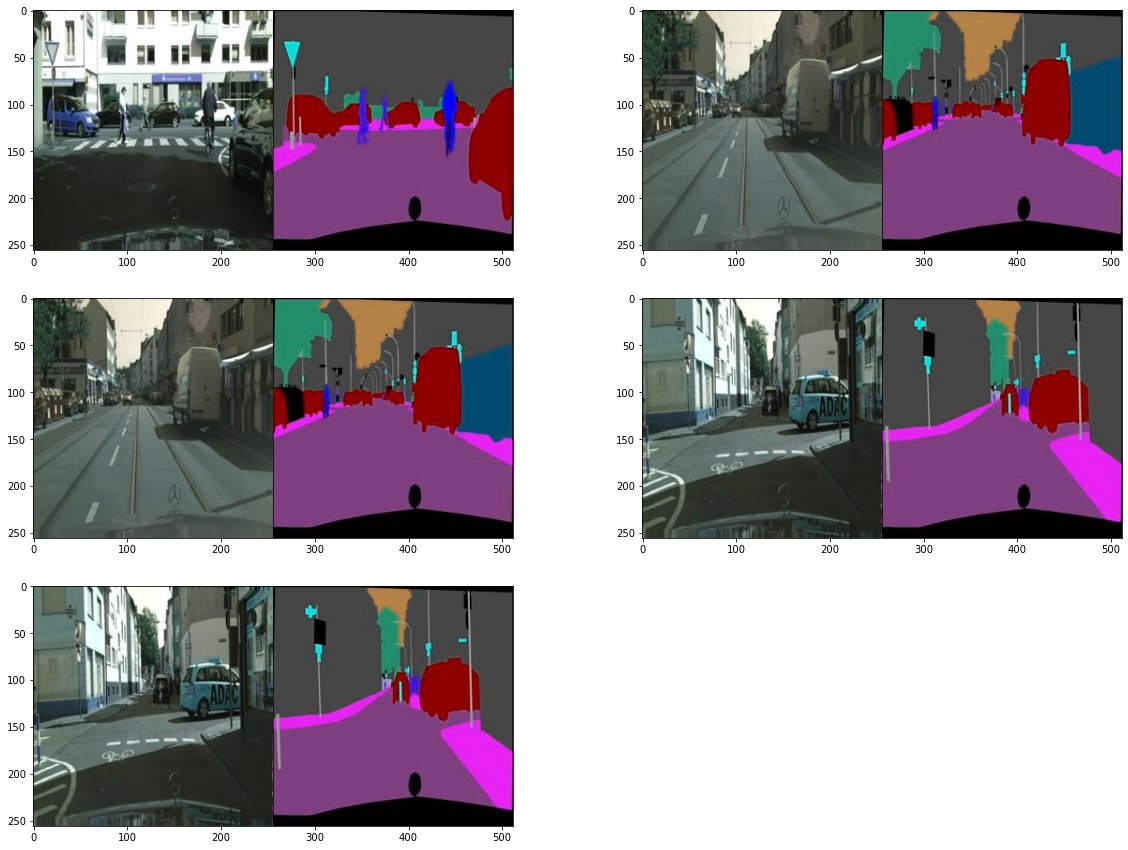

In [33]:
plt.figure(figsize=(20,15))
for i in range(1, 6):
    f = val_data_path + os.listdir(val_data_path)[np.random.randint(5)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

<br><br><br><br>

# 5. 시각화
스케치, 생성된 사진, 실제 사진 순

In [34]:
def visualization_valid(i):
    f = data_path + os.listdir(val_data_path)[i]
    sketch, colored = load_img(f)
    
    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))

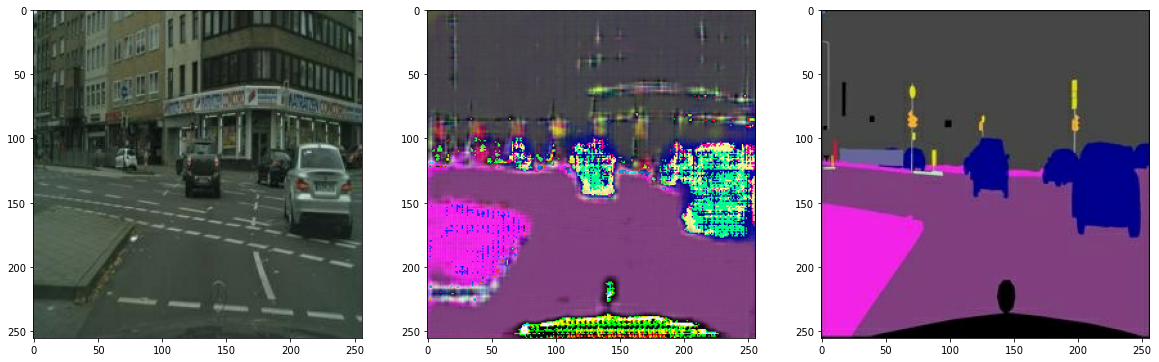

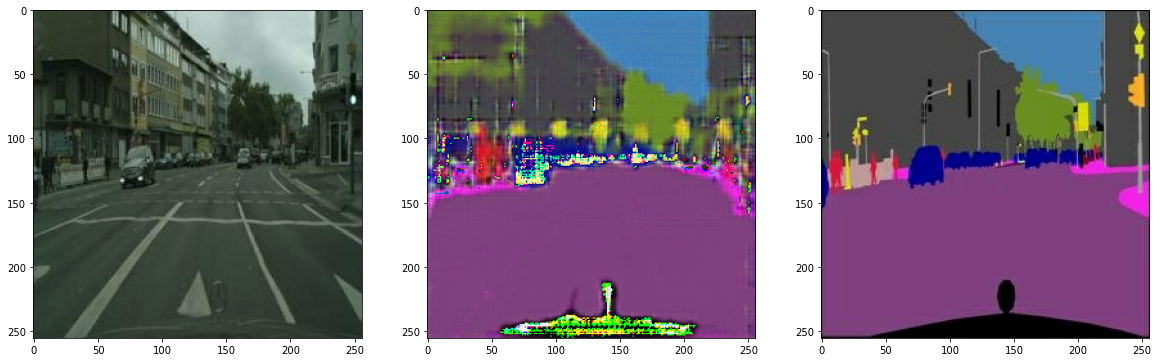

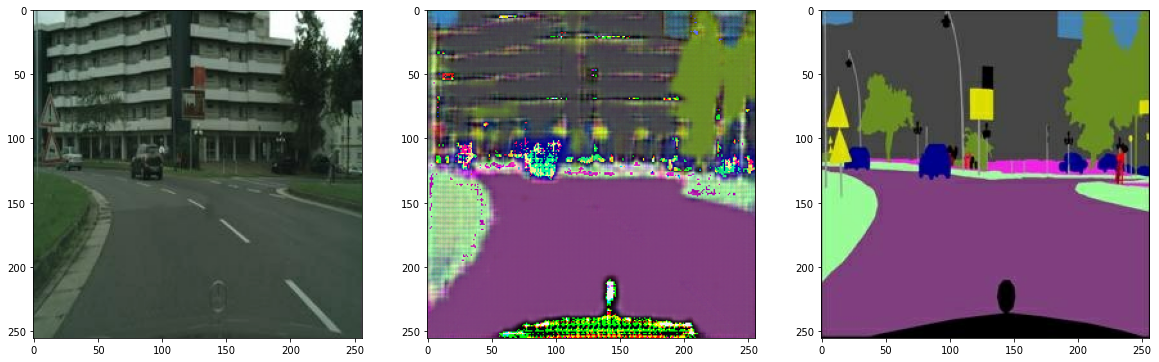

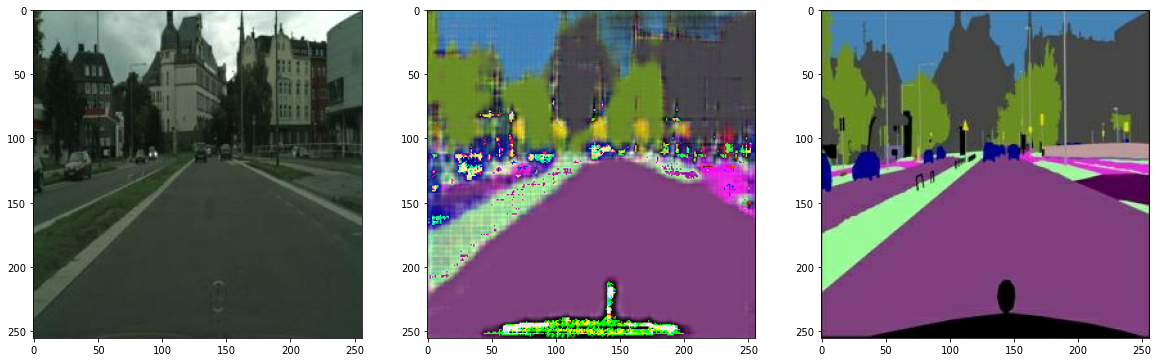

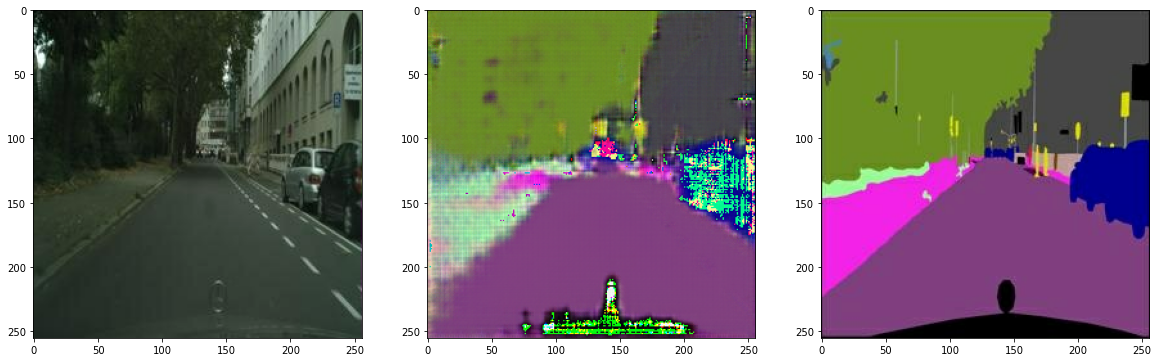

In [35]:
for i in range(5):
    visualization_valid(i)

<br><br><br><br>

## 회고
확실히 epoch가 늘어남에 따라 개선되고 있긴 하였다. 50epoch를 돌렸을 때 10epoch를 돌렸을 때보다 경계선이 더 명확해지는 것이 확인되었다. 시간이 된다면 500 epoch를 돌려보고 논문처럼 유사하게 나오는지 확인해보면 재밌을 것 같다.